<a href="https://colab.research.google.com/github/Anusha-Kasina/weed_detection/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import os
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization)
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import cv2
from easydict import EasyDict
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers

Using TensorFlow backend.


In [2]:
import os
#kaggle username from api token 
os.environ['KAGGLE_USERNAME'] = "anushakasina"
#kaggle key from api token
os.environ['KAGGLE_KEY'] ="ddb898e4090e073a6d8ebd4a4a47701c"
#dataset path for downloading the data
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

100% 2.37G/2.37G [00:32<00:00, 20.2MB/s]



In [3]:
from zipfile import ZipFile
#filename = zip file path 
file_name = "/content/weed-detection-in-soybean-crops.zip"
#to extract the zip file
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [0]:
os.mkdir("/content/train_data")
os.mkdir("/content/train_data/broadleaf")
os.mkdir("/content/train_data/grass")
os.mkdir("/content/train_data/soil")
os.mkdir("/content/train_data/soybean")


In [0]:
os.mkdir("/content/test_data")
os.mkdir("/content/test_data/broadleaf")
os.mkdir("/content/test_data/grass")
os.mkdir("/content/test_data/soil")
os.mkdir("/content/test_data/soybean")

In [0]:
from shutil import copyfile 
import random

In [7]:
def split_data(source,training,testing,split_size):
  files = []
  for filename in os.listdir(source):
    file = source+filename
    files.append(filename)
    training_length = int(len(files)*split_size)
    shuffled_set = random.sample(files,len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]
  for filename in training_set:
    this_file = source+filename 
    destination = training+filename 
    copyfile(this_file,destination)        
  for filename in testing_set:
    this_file = source+filename 
    destination = testing+filename 
    copyfile(this_file,destination)
#split_size = 0.8
split_data("/content/dataset/broadleaf/","/content/train_data/broadleaf/","/content/test_data/broadleaf/",0.8)
split_data("/content/dataset/grass/","/content/train_data/grass/","/content/test_data/grass/",0.8)
split_data("/content/dataset/soil/","/content/train_data/soil/","/content/test_data/soil/",0.8)
split_data("/content/dataset/soybean/","/content/train_data/soybean/","/content/test_data/soybean/",0.8)
print("done")

done


In [8]:
print("train-data-broadleaf",len(os.listdir('/content/train_data/broadleaf')),end=",")
print("test-data-broadleaf",len(os.listdir('/content/test_data/broadleaf')),end="\n")
print("train-data-grass",len(os.listdir('/content/train_data/grass')),end=",")
print("test-data-grass",len(os.listdir('/content/test_data/grass')),end="\n")
print("train-data-soil",len(os.listdir('/content/train_data/soil')),end=",")
print("test-data-soil",len(os.listdir('/content/test_data/soil')),end="\n")
print("train-data-soybean",len(os.listdir('/content/train_data/soybean')),end=",")
print("test-data-soybean",len(os.listdir('/content/test_data/soybean')),end="\n")

train-data-broadleaf 952,test-data-broadleaf 239
train-data-grass 2816,test-data-grass 704
train-data-soil 2599,test-data-soil 650
train-data-soybean 5900,test-data-soybean 1476


In [0]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [10]:
train_dir = '/content/train_data'
test_dir = '/content/test_data'

train_gen_obj = ImageDataGenerator(rescale = 1.0/255.0)
test_gen_obj = ImageDataGenerator(rescale = 1.0/255.0)

train_gen = train_gen_obj.flow_from_directory(train_dir, batch_size = 128, target_size = (150, 150), class_mode = 'categorical')

test_gen = test_gen_obj.flow_from_directory(test_dir, batch_size = 64, target_size = (150, 150), class_mode = 'categorical')


Found 12267 images belonging to 4 classes.
Found 3069 images belonging to 4 classes.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow as tf
import os

In [12]:
model_vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(150,150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [0]:
for layer in model_vgg16.layers:
    layer.trainable = False

In [0]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.3)
leaky_relu.__name__ = 'leaky_relu'
flat1 = tf.keras.layers.Flatten()(model_vgg16.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation=leaky_relu)(flat1)
drop1 = tf.keras.layers.Dropout(0.5)(class1)
class2 = tf.keras.layers.Dense(256, activation=leaky_relu)(drop1)
drop2 = tf.keras.layers.Dropout(0.5)(class2)
output = tf.keras.layers.Dense(4, activation='softmax')(drop2)

model_vgg16 = tf.keras.models.Model(inputs=model_vgg16.inputs, outputs=output)

In [15]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:

model_vgg16.compile(optimizer=keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['acc'])

In [18]:
history = model_vgg16.fit(train_gen, epochs=10,
                          validation_data=test_gen)

Epoch 1/10
96/96 [==============================] - 89s 922ms/step - loss: 0.3459 - acc: 0.8838 - val_loss: 0.0838 - val_acc: 0.9697
Epoch 2/10
96/96 [==============================] - 76s 790ms/step - loss: 0.1043 - acc: 0.9635 - val_loss: 0.0697 - val_acc: 0.9752
Epoch 3/10
96/96 [==============================] - 74s 770ms/step - loss: 0.0750 - acc: 0.9744 - val_loss: 0.0587 - val_acc: 0.9804
Epoch 4/10
96/96 [==============================] - 75s 776ms/step - loss: 0.0780 - acc: 0.9751 - val_loss: 0.0594 - val_acc: 0.9827
Epoch 5/10
96/96 [==============================] - 77s 802ms/step - loss: 0.0437 - acc: 0.9850 - val_loss: 0.0730 - val_acc: 0.9762
Epoch 6/10
96/96 [==============================] - 77s 799ms/step - loss: 0.0498 - acc: 0.9835 - val_loss: 0.0495 - val_acc: 0.9850
Epoch 7/10
96/96 [==============================] - 76s 787ms/step - loss: 0.0396 - acc: 0.9868 - val_loss: 0.0755 - val_acc: 0.9759
Epoch 8/10
96/96 [==============================] - 74s 768ms/step - 

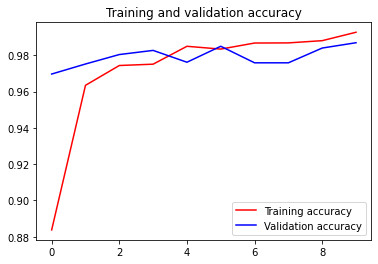

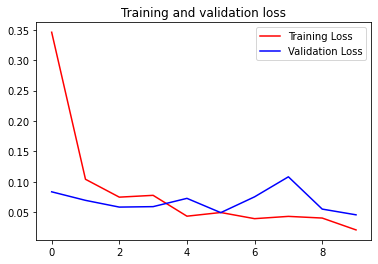

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
 import os
os.mkdir("testing_outputs")

In [0]:
source = "/content/testing_outputs/"
from skimage.transform import resize
from skimage.transform import resize
classification=['broad','grass','soil','soya']
for filename in os.listdir(source):
  os.chdir(source)
  this_file = source+filename 
  this_file = this_file[25:]
  new_image=plt.imread(this_file)
  print(this_file)
  

  resized_image = resize(new_image, (150,150,3))
  
  predictions = model_vgg16.predict(np.array( [resized_image] ))
  list_index = [0,1,2,3]
  x = predictions
  for i in range(4):
    for j in range(4):
      if x[0][list_index[i]] > x[0][list_index[j]]:
        temp = list_index[i]
        list_index[i] = list_index[j]
        list_index[j] = temp
  print(list_index)
  print(classification[list_index[0]])
  if(classification[list_index[0]]=='broad'):
    print('weed')
    
    print('...........')
    

  else:
    print("non weed")
    print('...........')  
    
    

101 (1).tif
[3, 2, 0, 1]
soya
non weed
...........
4327.tif
[3, 1, 0, 2]
soya
non weed
...........
102.tif
[0, 3, 1, 2]
broad
weed
...........
1.tif
[0, 3, 1, 2]
broad
weed
...........
1025.tif
[0, 1, 3, 2]
broad
weed
...........
106.tif
[0, 1, 3, 2]
broad
weed
...........
100.tif
[1, 0, 3, 2]
grass
non weed
...........
1018.tif
[2, 0, 3, 1]
soil
non weed
...........
3565.tif
[3, 1, 0, 2]
soya
non weed
...........
